In [1]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score


In [ ]:
# -----------------------------
# Load and preprocess CSV
# -----------------------------
df = pd.read_csv("./Data_Entry_2017_v2020.csv")
train_val = pd.read_csv("./train_val_list.txt", header=None).rename({0: "Image Index"}, axis=1)
train_val['dataset'] = 'train_val'
test = pd.read_csv("./test_list.txt", header=None).rename({0: "Image Index"}, axis=1)
test['dataset'] = 'test'
# Merge train_val and test


print('train_val.shape[0] + test.shape[0] == df.shape[0]')
print(train_val.shape[0] + test.shape[0] == df.shape[0])
labels = pd.concat([train_val, test], axis=0)
df = df.merge(labels, on="Image Index", how="left")


# Split multi-labels
df["Finding Labels"] = df["Finding Labels"].apply(lambda x: x.split('|'))

# Binarize labels
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["Finding Labels"])
label_names = list(mlb.classes_)  # 14 labels

# Add one-hot columns
for i, label in enumerate(label_names):
    df[label] = labels[:, i]
    


train_val.shape[0] + test.shape[0] == df.shape[0]
True


In [3]:
# -----------------------------
# Patient-level train/val/test split
# -----------------------------
unique_patients = df[df['dataset']=='train_val']["Patient ID"].unique()
train_ids, val_ids = train_test_split(unique_patients, test_size=0.15, random_state=100)

train_df = df[df["Patient ID"].isin(train_ids)]
train_df['dataset'] = 'train'
val_df = df[df["Patient ID"].isin(val_ids)]
val_df['dataset'] = 'val'
test_df = df[df['dataset']=='test']


total_images = len(train_df) + len(val_df) + len(test_df)
print(f"\nImage distribution - Train: {len(train_df)/total_images:.2%}, Val: {len(val_df)/total_images:.2%}, Test: {len(test_df)/total_images:.2%}")

for label in label_names:
    print(f"{label}: {train_df[label].mean()} train, {val_df[label].mean()} val")

test_df = test_df.drop(columns=['dataset'])
train_df = train_df.drop(columns=['dataset'])
val_df = val_df.drop(columns=['dataset'])
# Save the dataframes



Image distribution - Train: 65.67%, Val: 11.50%, Test: 22.83%
Atelectasis: 0.09434628495375715 train, 0.10340547668916299 val
Cardiomegaly: 0.019855227954857196 train, 0.01900550771856334 val
Consolidation: 0.032594081458041914 train, 0.03506322240322706 val
Edema: 0.016134070321730747 train, 0.0147389651694981 val
Effusion: 0.0995205953852213 train, 0.1032503296873788 val
Emphysema: 0.01628345986174677 train, 0.01737646419982934 val
Fibrosis: 0.014354976708812625 train, 0.01504925917306648 val
Hernia: 0.0016976084092730163 train, 0.001241176014273524 val
Infiltration: 0.15943938179892167 train, 0.15840508882165852 val
Mass: 0.04679966862683851 train, 0.04561321852455201 val
No Finding: 0.584751402224546 train, 0.577379567139865 val
Nodule: 0.05460866730949438 train, 0.053292995112869446 val
Pleural_Thickening: 0.025776486086401477 train, 0.02668528430688077 val
Pneumonia: 0.010212812190186465 train, 0.009619114110619812 val
Pneumothorax: 0.03019026795051132 train, 0.03211542936932744

/var/folders/r7/dfxvf5_d7m57v2c52lgnxm780000gn/T/ipykernel_27358/3870712805.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['dataset'] = 'train'
/var/folders/r7/dfxvf5_d7m57v2c52lgnxm780000gn/T/ipykernel_27358/3870712805.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['dataset'] = 'val'


In [ ]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False) 

<Axes: >

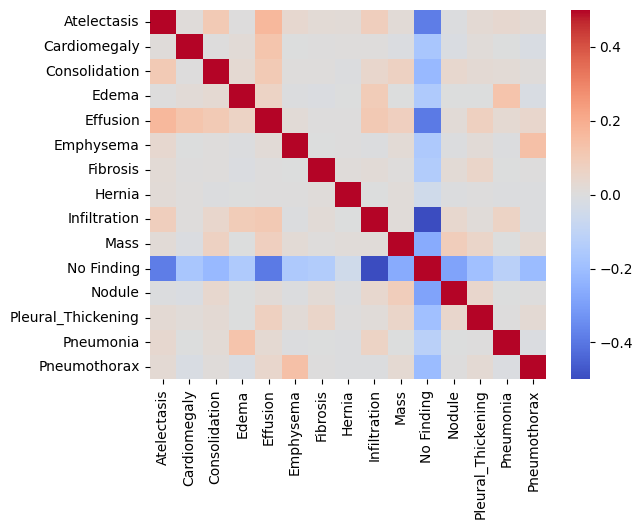

In [ ]:
# Label Correlations

sns.heatmap(train_df[label_names].corr(), cmap='coolwarm',vmin = -0.5, vmax = 0.5)